<a href="https://colab.research.google.com/github/PRIYADHARSHINI-star/Camouflage-Object-Detection/blob/main/Camouflage_Object_Detection_Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Update CUDA for TF 2.5
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
!dpkg -i libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
# Check if package has been installed
!ls -l /usr/lib/x86_64-linux-gnu/libcudnn.so.*
# Upgrade Tensorflow
!pip install --upgrade tensorflow==2.5.0

--2023-04-15 10:09:26--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.39.144
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 430460776 (411M) [application/x-deb]
Saving to: ‘libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb’

libcudnn8_8.1.0.77- 100%[===================>] 410.52M  67.9MB/s    in 5.8s    

2023-04-15 10:09:31 (70.7 MB/s) - ‘libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb’ saved [430460776/430460776]

dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 122349 files and directories currently installed.)
Preparing to unpack libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+cuda11.2) over (8.7.0.84-1+cuda11.8) ...
Setting up libcudnn8 (8.1.0.77-1+

In [ ]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
COCO_MODEL_PATH = "/content/drive/MyDrive/CAT-2_PROJECT_WEIGHTS/mask_rcnn_coco.h5"

Mounted at /content/drive


In [ ]:
import os
import sys

In [ ]:
ROOT_DIR = os.path.abspath("./")
sys.path.append(ROOT_DIR)
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_LOGS_DIR = 'logs'
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version

In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
!wget https://psfiles.link/project/mask_rcnn_colab/mrcnn_demo_PIBVGJTEFX.zip
!unzip mrcnn_demo_PIBVGJTEFX.zip
import sys
sys.path.append("/content/maskrcnn_colab/mrcnn_demo")
from m_rcnn import *
%matplotlib inline

--2023-04-15 10:13:36--  https://psfiles.link/project/mask_rcnn_colab/mrcnn_demo_PIBVGJTEFX.zip
Resolving psfiles.link (psfiles.link)... 34.90.26.83
Connecting to psfiles.link (psfiles.link)|34.90.26.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59799 (58K) [application/zip]
Saving to: ‘mrcnn_demo_PIBVGJTEFX.zip’

mrcnn_demo_PIBVGJTE 100%[===================>]  58.40K   286KB/s    in 0.2s    

2023-04-15 10:13:38 (286 KB/s) - ‘mrcnn_demo_PIBVGJTEFX.zip’ saved [59799/59799]

Archive:  mrcnn_demo_PIBVGJTEFX.zip
   creating: maskrcnn_colab/
   creating: maskrcnn_colab/mrcnn_demo/
  inflating: maskrcnn_colab/mrcnn_demo/config.py  
  inflating: maskrcnn_colab/mrcnn_demo/model.py  
  inflating: maskrcnn_colab/mrcnn_demo/m_rcnn.py  
  inflating: maskrcnn_colab/mrcnn_demo/parallel_model.py  
  inflating: maskrcnn_colab/mrcnn_demo/utils.py  
  inflating: maskrcnn_colab/mrcnn_demo/visualize.py  
VERS 0.5 - updated 11/03/2023


/content/maskrcnn_colab/mrcnn_demo/model.py:2378: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':


... done downloading pretrained model!


In [ ]:
!git clone --quiet https://github.com/ahmedfgad/Mask-RCNN-TF2
#!mv Mask-RCNN-TF2/* .
!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

In [ ]:
ROOT_DIR = os.path.abspath('Mask-RCNN-TF2/')
sys.path.append(ROOT_DIR)

In [ ]:
from mrcnn_demo.visualize import display_instances, display_top_masks
from mrcnn_demo.utils import extract_bboxes
from mrcnn_demo.utils import Dataset
from matplotlib import pyplot as plt
from mrcnn_demo.config import Config

In [ ]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()

        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids



In [ ]:
!mv Mask-RCNN-TF2/* .

In [ ]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/dataset/train/labels/Annotation_COCO.json', '/content/dataset/train')
dataset_train.prepare()

In [ ]:
dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/dataset/train/labels/Annotation_COCO.json', '/content/dataset/train')
dataset_val.prepare()

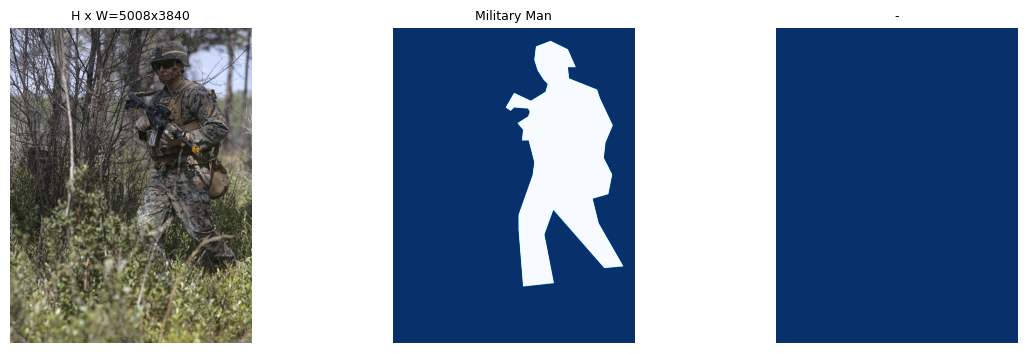

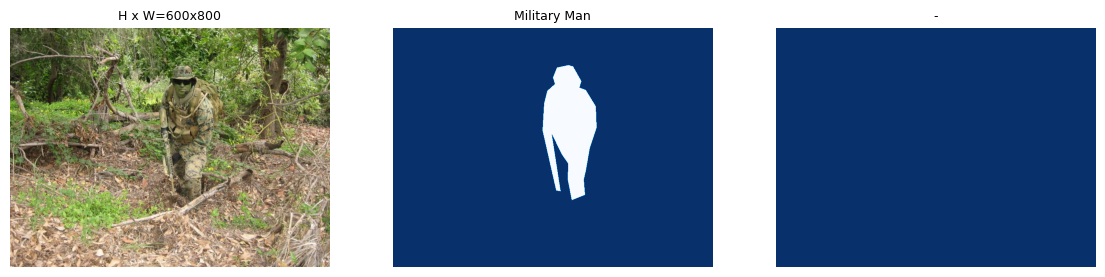

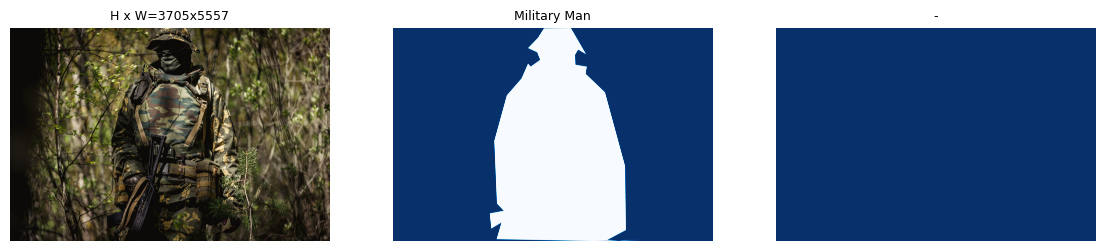

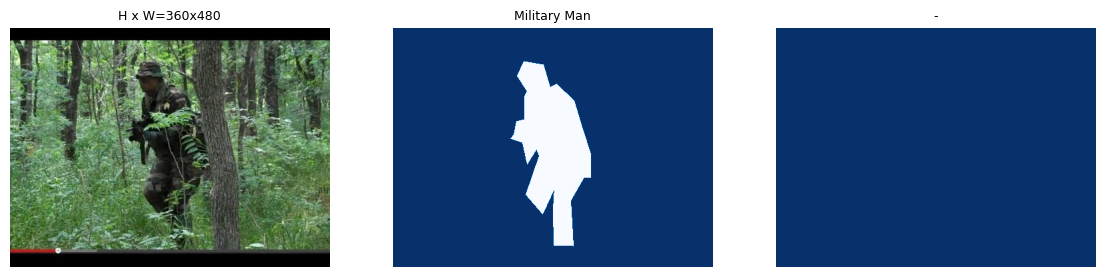

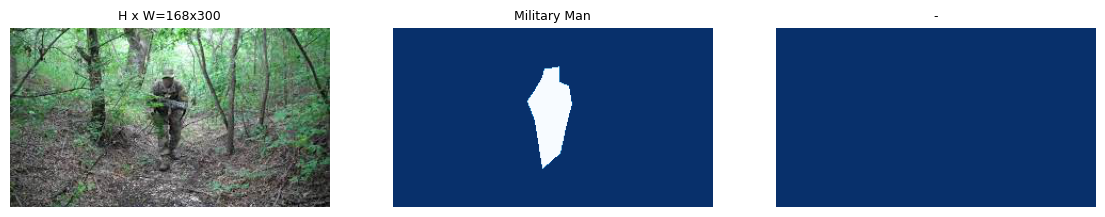

In [ ]:
dataset = dataset_train
image_ids = dataset.image_ids
#image_ids = np.random.choice(dataset.image_ids, 3)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    display_top_masks(image, mask, class_ids, dataset.class_names, limit=2)  #limit to total number of classes


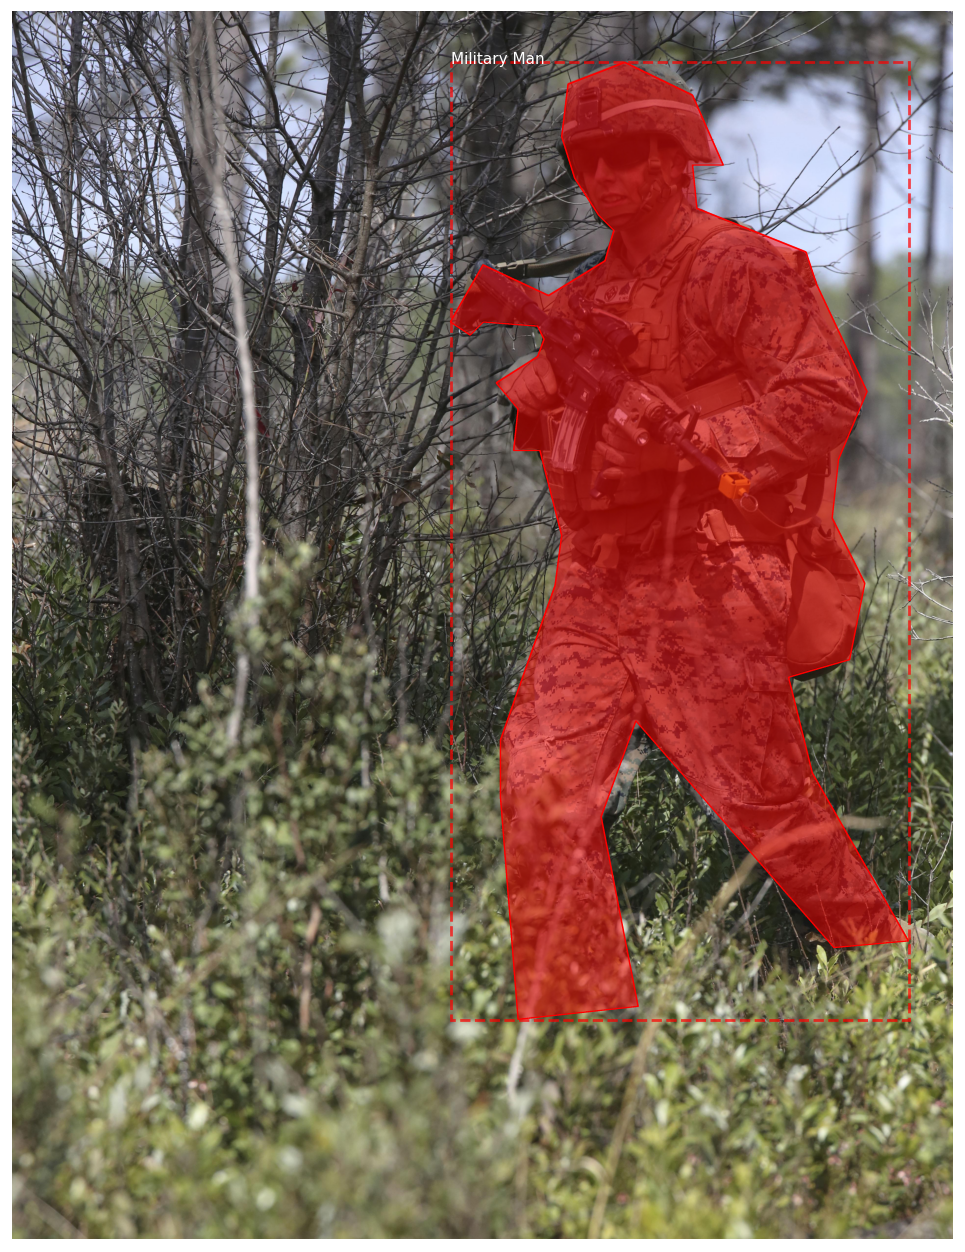


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
ETF_C                          2
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE      

In [ ]:
# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

# display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
# dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)


# define a configuration for the model
class MilitaryConfig(Config):
	NAME = "military_cfg_coco"
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
	NUM_CLASSES = 1
	DETECTION_MIN_CONFIDENCE = 0.9
	STEPS_PER_EPOCH = 80
	LEARNING_RATE = 0.005
# prepare config
config = MilitaryConfig()
config.display()

In [ ]:
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:
model = modellib.MaskRCNN(mode='training', model_dir=MODEL_DIR, config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(dataset_train, dataset_train, learning_rate=config.LEARNING_RATE, epochs=25, layers='heads')


Starting at epoch 0. LR=0.005

Checkpoint Path: /content/maskrcnn_colab/logs/military_cfg_coco20230415T1028/mask_rcnn_military_cfg_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistribute

KeyboardInterrupt: ignored

In [ ]:
from mrcnn_demo.model import load_image_gt
from mrcnn_demo.model import mold_image
from mrcnn_demo.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle

In [ ]:
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "military_cfg_coco"
	# number of classes (background + Blue Marbles + Non Blue marbles)
	NUM_CLASSES = 1
	# Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [ ]:
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

In [ ]:
# create config
cfg = PredictionConfig()
# define the model
model = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=config)
# load model weights
model.load_weights('/content/maskrcnn_colab/logs/military_cfg_coco20230415T1028/mask_rcnn_military_cfg_coco_0002.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(dataset_train, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
# test_mAP = evaluate_model(dataset_train, model, cfg)
# print("Test mAP: %.3f" % test_mAP)

Instructions for updating:
Use fn_output_signature instead


Re-starting from epoch 2
Train mAP: 1.000


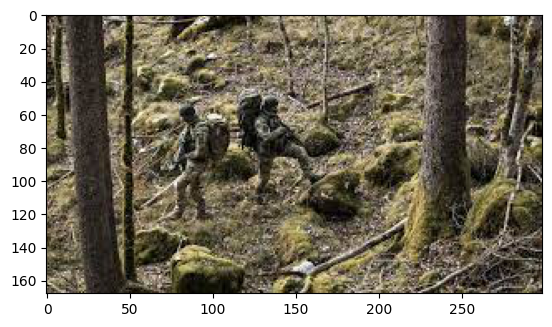

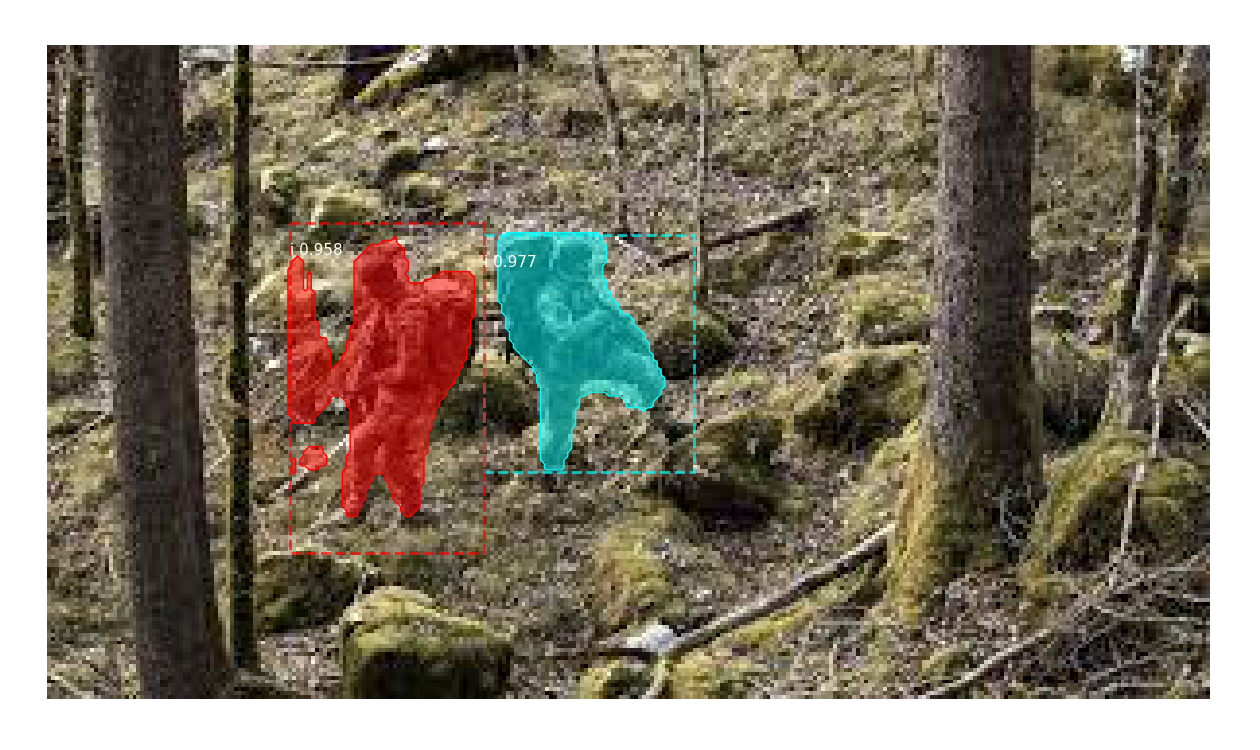

In [ ]:
marbles_img = skimage.io.imread("/content/dataset/val/download.jpg")
plt.imshow(marbles_img)

detected = model.detect([marbles_img])
results = detected[0]
class_names = 'Military Man'
display_instances(marbles_img, results['rois'], results['masks'],
                  results['class_ids'], class_names, results['scores'])